In [173]:
import pandas as pd
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from datetime import date, timedelta
import requests
from bs4 import BeautifulSoup
import time
import re
import json
from dotenv import load_dotenv
load_dotenv()
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

In [9]:
# Set up environment variables
NEWSAPI_KEY = os.getenv('NEWSAPI_KEY')
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

In [113]:
start_date = date.today() - timedelta(days=1)
end_date = date.today()


llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0
)

# Define the state
class PipelineState:
    news_source : list
    credible_news_id : str
    articles : list
    news_summary: list


In [87]:
# Extract news provider list

def fetch_news_source():
    """Fetches news source provide from News API - id, name, description, url, category, language, country"""
    
    source_url = "https://newsapi.org/v2/sources"
    
    params_general = {
        "apiKey": NEWSAPI_KEY, 
        "language": "en",
        "country": "us",
        "category": "general"
    }

    params_tech = {
        "apiKey": NEWSAPI_KEY, 
        "language": "en",
        "country": "us",
        "category": "technology"
    }


    news_general = requests.get(source_url, params=params_general).json()
    news_tech = requests.get(source_url, params=params_tech).json()
    news_source = news_general.get("sources", []) + news_tech.get("sources", [])

    # source_list.to_csv('data/source_list.csv', index=False) 
    return(news_source)


In [96]:
def check_news_source(news_source):
    """Fetches factual reporting, traffic, and credibility score from Media Bias/Fact Check."""
    
    news_score = pd.DataFrame()

    base_search_url = "https://mediabiasfactcheck.com/?s="
    headers = {"User-Agent": "Mozilla/5.0"}
    
    for news in news_source:
        # Extract extact url for each news
        response = requests.get(base_search_url + news["url"], headers=headers)
        response.raise_for_status()  # Raise an error for bad responses
        soup = BeautifulSoup(response.text, "html.parser")
        result = soup.find("h3", class_="entry-title")
        if not result or not result.a:
            return {"id": news["id"], "url": news["url"], "factual_reporting": "NA", "traffic": "NA", "credibility": "NA"}

        source_page_url = result.a["href"]

        # Extract information for each news
        response = requests.get(source_page_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        factual_reporting, traffic, credibility = "NA", "NA", "NA"

        for para in soup.find_all("p"):
            if "Factual Reporting:" in para.text:
                factual_match = re.search(r"Factual Reporting:\s*([^(\n]+)", para.text)
                traffic_match = re.search(r"Traffic/Popularity:\s*([^\n]+)", para.text)
                credibility_match = re.search(r"MBFC Credibility Rating:\s*([^\n]+)", para.text)
                
                factual_reporting = factual_match.group(1) if factual_match else "NA"
                traffic = traffic_match.group(1) if traffic_match else "NA"
                credibility = credibility_match.group(1) if credibility_match else "NA"
                
                news_score = pd.concat([news_score, pd.DataFrame(
                    {'id': [news['id']],
                     'url': [news['url']],
                     'factual_reporting': [factual_reporting],
                     'traffic': [traffic],
                     'credibility': [credibility]
                     })])
                
                break
        
        time.sleep(3) 

    # news_score.to_csv('data/news_credibility.csv', index=False)

    credible_news = news_score[((news_score['factual_reporting'].str.contains('HIGH')) | (news_score['factual_reporting'].str.contains('MOSTLY'))) &
                (news_score['traffic'].str.contains('High')) &
                (news_score['credibility'].str.contains('HIGH'))]
    credible_news_id = ','.join(credible_news['id'])
    
    # with open('data/sources_final.txt', 'w') as f:
    #     f.write(sources_final)

    return (credible_news_id)

In [107]:
def fetch_news(credible_news_id):
    news_url = "https://newsapi.org/v2/everything"

    # Define your search query with OR
    query = "AI OR artificial%20intelligence OR machine%20learning OR data%20science OR tech"

    # Set up request parameters
    params = {
        "q": query, 
        "language": "en",
        "sortBy": "Popularity",
        "from": str(start_date) + 'T05:00:01',
        "to": str(end_date) + 'T05:00:01',
        "sources": credible_news_id,
        # "searchIn": "title,description"
        "apiKey": NEWSAPI_KEY 
    }

    # Make the request
    response = requests.get(news_url, params=params)
    articles = [{key: article[key] for key in ['title','description','content','url'] if key in article} for article in response.json()['articles']]
    return(articles)



In [114]:
def summarize_articles(llm, articles):
    prompt= """You are an AI news summarization assistant. 
    Your task is to analyze a collection of news articles, identify the most frequently mentioned news topics, summarize them, and select the best representative article for each.

    - Introduction
    1. Group Similar News Articles: Identify common themes among the articles and group them by topic.  
    2. Filter for Tech-Related News: Only include topics related to AI, machine learning, data science, cloud computing, automation, and major tech breakthroughs. Ignore irrelevant news.  
    3. Summarize Each Topic: Provide a concise summary of each grouped topic.  
    4. Select the Best Representative URL: Choose one URL that best represents the topic (preferably from a reputable source).  
    5. Format Output as JSON.

    - Input Data
    {articles}"""

    summary_prompt = PromptTemplate(
        input_variables=["articles"],
        template=prompt
    )

    result = llm.invoke(summary_prompt.format(articles=articles))
    result_json = result.to_json()['kwargs']['content'].strip("'```json\n")
    news_summary = json.loads(result_json)['news_summary']
    news_summary = [{'title': k} | v for k, v in news_summary.items()]
    return(news_summary)

In [168]:
def skip_source(state: PipelineState) -> str:
    """Decide whether to fetch news source and check crediblity or use saved credible source list"""
    if state.get('skip_source', True):
        return("load_source")
    return("fetch_news_source")

def load_source(state: PipelineState):
    with open('data/sources_final.txt', 'r') as f:
        credible_news_id = f.read()
    return(credible_news_id)


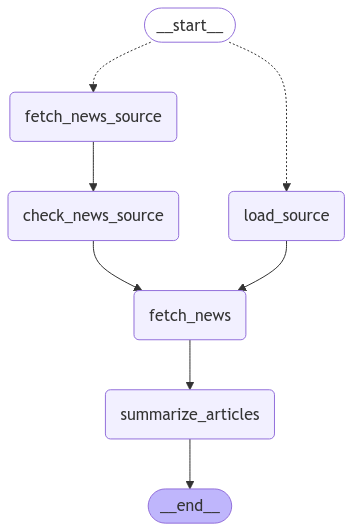

In [175]:
# Graph
builder = StateGraph(PipelineState)

# Define nodes: these do the work
builder.add_node('load_source', load_source)
builder.add_node("fetch_news_source", fetch_news_source)
builder.add_node("check_news_source", check_news_source)
builder.add_node("fetch_news", fetch_news)
builder.add_node("summarize_articles", summarize_articles)

# Define edges: these determine how the control flow moves
builder.add_conditional_edges(START, skip_source, 
                              {"fetch_news_source": "fetch_news_source",
                               "load_source": "load_source"})
builder.add_edge("fetch_news_source", "check_news_source")
builder.add_edge("check_news_source", "fetch_news")
builder.add_edge("load_source", "fetch_news")
builder.add_edge("fetch_news", "summarize_articles")
builder.add_edge("summarize_articles", END)

react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))